In [44]:
# Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import pandas as pd
import random
import cv2
import shutil
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image

In [45]:
# Dataset URLs
dataset_url = "https://thor.robots.ox.ac.uk/pets/images.tar.gz"
annotations_url = "https://thor.robots.ox.ac.uk/pets/annotations.tar.gz"

# Download images & annotations
!wget $dataset_url -O images.tar.gz
!wget $annotations_url -O annotations.tar.gz

# Extract files
!mkdir -p dataset/images
!tar -xzf images.tar.gz -C dataset/images
!mkdir -p dataset/annotations
!tar -xzf annotations.tar.gz -C dataset/annotations

# Define dataset paths
dataset_path = "dataset/images"
annotation_file = "dataset/annotations/list.txt"

# Ensure `list.txt` exists
if not os.path.exists(annotation_file):
    raise FileNotFoundError("Annotations file (list.txt) not found! Check dataset extraction.")
else:
    print("Annotations file found.")


--2025-01-30 19:14:38--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz        13%[=>                  ] 105.42M  8.79MB/s    eta 84s    ^C
--2025-01-30 19:14:54--  https://thor.robots.ox.ac.uk/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  5.06MB/s    in 4.5s    

2025-01-30 19:14:59 (4.08 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]

images/samoyed_81.jpg: trun

In [27]:
# Read list.txt and create a DataFrame for all images (cats & dogs)
data = []
with open(annotation_file, "r") as f:
    lines = f.readlines()[6:]  # Skip header lines

for line in lines:
    parts = line.split()
    filename = parts[0] + ".jpg"  # Image filenames in list.txt do not include .jpg extension
    label = int(parts[1])  # Second column contains label (1-37)
    
    # Determine if it's a cat or dog (labels 1-12 are cats, 13-37 are dogs)
    category = "Cat" if label <= 12 else "Dog"
    
    data.append([os.path.join(dataset_path, filename.lower()), category])

# Save the image paths and labels to a CSV file
df = pd.DataFrame(data, columns=["filepath", "label"])
df.to_csv("pet_data.csv", index=False)
print(f"✅ Created pet_data.csv with {len(df)} images.")


✅ Created pet_data.csv with 7349 images.


In [31]:
# Remove corrupt images
for filename in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, filename)
    
    try:
        img = Image.open(img_path)
        img.verify()  # Check if readable
    except:
        print(f"Corrupt image detected & removed: {img_path}")
        os.remove(img_path)  # Delete

print("Corrupt images removed.")


Corrupt image detected & removed: dataset/images/Abyssinian_102.mat
Corrupt image detected & removed: dataset/images/Abyssinian_100.mat
Corrupt image detected & removed: dataset/images/Abyssinian_101.mat
Corrupt images removed.


In [ ]:
# Read list.txt and create a DataFrame with pet breeds (cats & dogs)
data = []
with open(annotation_file, "r") as f:
    lines = f.readlines()[6:]  # Skip header lines

for line in lines:
    parts = line.split()
    filename = parts[0] + ".jpg"  # Image filenames in list.txt do not include .jpg extension
    label = int(parts[1])  # Second column contains label (1-37)
    
    # Get breed name from filename (e.g., "Siamese_1.jpg" → "Siamese")
    breed_name = "_".join(filename.split("_")[:-1])
    
    data.append([os.path.join(dataset_path, filename.lower()), breed_name])

# Save the image paths and labels to a CSV file
df = pd.DataFrame(data, columns=["filepath", "label"])
df.to_csv("pet_breed_data.csv", index=False)
print(f"Created pet_breed_data.csv with {len(df)} images.")


Created pet_breed_data.csv with 7349 images.


In [33]:
# Load CSV
df = pd.read_csv("pet_breed_data.csv")

# Convert labels to numerical classes
class_names = sorted(df["label"].unique())  # Get all breed names
class_to_index = {name: i for i, name in enumerate(class_names)}  # Map breed names to numbers
df["label_index"] = df["label"].map(class_to_index)  # Convert labels to numbers

# Split into train (80%) and test (20%)
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

print(f"Training: {len(train_df)} images | Testing: {len(test_df)} images")

# Convert into TensorFlow dataset
def load_and_preprocess(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224]) / 255.0  # Resize & normalize
    return img, label

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df["filepath"], train_df["label_index"]))
test_ds = tf.data.Dataset.from_tensor_slices((test_df["filepath"], test_df["label_index"]))

train_ds = train_ds.map(load_and_preprocess).batch(32).shuffle(500)
test_ds = test_ds.map(load_and_preprocess).batch(32)

print("Dataset loaded dynamically from CSV!")


Training: 5879 images | Testing: 1470 images
Dataset loaded dynamically from CSV!


In [ ]:
# Load MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model

# Add classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # prevent Overfitting
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)  # prevent Overfitting
x = Dense(len(class_names), activation="softmax")(x)  # Multi-class classification

# Compile model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(train_ds, validation_data=test_ds, epochs=8)  # reduce Epochs

# Save model
model.save("pet_breed_classifier.keras")


Epoch 1/8


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - accuracy: 0.5277 - loss: 1.7788 - val_accuracy: 0.8619 - val_loss: 0.4185
Epoch 2/8


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - accuracy: 0.8505 - loss: 0.4483 - val_accuracy: 0.8810 - val_loss: 0.3341
Epoch 3/8


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 139ms/step - accuracy: 0.8852 - loss: 0.3412 - val_accuracy: 0.8816 - val_loss: 0.3350
Epoch 4/8


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 141ms/step - accuracy: 0.9064 - loss: 0.2711 - val_accuracy: 0.8850 - val_loss: 0.3427
Epoch 5/8


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.9154 - loss: 0.2356 - val_accuracy: 0.8823 - val_loss: 0.3413
Epoch 6/8


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step - accuracy: 0.9280 - loss: 0.2018 - val_accuracy: 0.8891 - val_loss: 0.3208
Epoch 7/8


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - accuracy: 0.9364 - loss: 0.1878 - val_accuracy: 0.9061 - val_loss: 0.2993
Epoch 8/8


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.9511 - loss: 0.1494 - val_accuracy: 0.8884 - val_loss: 0.3442


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


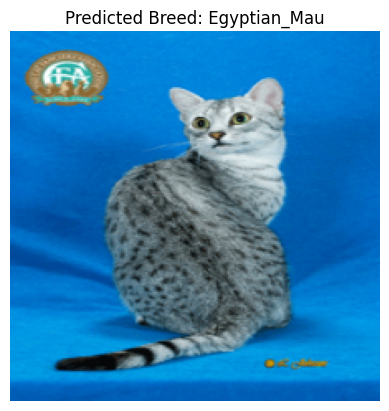

In [40]:
# Pick a random image from test set
random_image_path = random.choice(test_df["filepath"].tolist())

def predict_image(image_path):
    """Loads an image, preprocesses it, and predicts the pet breed."""
    
    if not os.path.exists(image_path):
        print(f"Error: Image path {image_path} not found!")
        return

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted Breed: {predicted_class}")
    plt.axis("off")
    plt.show()

# Predict a random image
predict_image(random_image_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


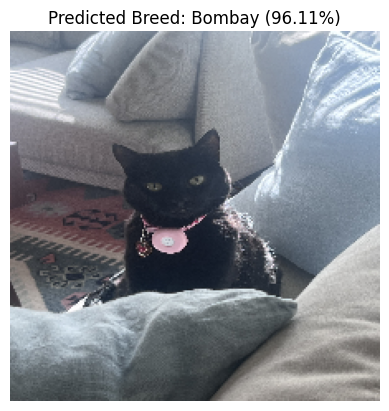

'Bombay'

In [46]:
def predict_custom_image(image_path):
    """Loads an image, preprocesses it, and predicts the pet breed."""
    
    if not os.path.exists(image_path):
        print(f"Error: Image path {image_path} not found!")
        return

    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img_array = np.expand_dims(img, axis=0) / 255.0  # Normalize
    
    # Make a prediction
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100  # Convert to percentage

    # Display the image with the prediction
    plt.imshow(img)
    plt.title(f"Predicted Breed: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

    return predicted_class

# Example Usage
image_path = "kali1.jpeg"  # Replace with your actual image filename
predict_custom_image(image_path)